# Imports

In [9]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, Bidirectional, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import bz2
import csv
import re

# Loading Dataset

In [10]:
import bz2


# Load a subset of the training data
with bz2.BZ2File("/kaggle/input/amazonreviews/train.ft.txt.bz2") as f:
    training_data = [f.readline().decode('utf-8').strip() for _ in range(20000)]

# Load a subset of the test data
with bz2.BZ2File("/kaggle/input/amazonreviews/test.ft.txt.bz2") as f:
    test_data = [f.readline().decode('utf-8').strip() for _ in range(10000)]

# Print the subset sizes
print("Training data subset size:", len(training_data))
print("Test data subset size:", len(test_data))

Training data subset size: 20000
Test data subset size: 10000


# Preparing Dataset

In [11]:
# Split the data into labels and texts
training_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in training_data]
training_texts = [re.sub(r'__label__\d ', '', line) for line in training_data]

test_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in test_data]
test_texts = [re.sub(r'__label__\d ', '', line) for line in test_data]

# Convert labels to binary (0 and 1)
training_labels = [0 if label == 1 else 1 for label in training_labels]
test_labels = [0 if label == 1 else 1 for label in test_labels]

In [12]:
print(test_labels[:4])
print("\n\n", test_texts[:4])

[1, 1, 0, 1]


 ['Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"', "One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of t

# Text Cleaning

In [13]:
# normally we use NLT library
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download stopwords if not already downloaded
nltk.download('stopwords')


def clean_text(text):
    """Cleans text by lowercasing, removing stopwords, and applying stemming."""
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters (keep spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize and remove stopwords, apply stemming
    words = text.split()
    words = [ps.stem(word) for word in words if word not in stop_words]
    
    # Join words back into a string
    return " ".join(words)

# Apply function to training and test texts
training_texts = [clean_text(text) for text in training_texts]
test_texts = [clean_text(text) for text in test_texts]

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [14]:
training_texts[0]

'stune even nongam sound track beauti paint seneri mind well would recomend even peopl hate vid game music play game chrono cross game ever play best music back away crude keyboard take fresher step grate guitar soul orchestra would impress anyon care listen'

# Tokenization

In [15]:
# model will not take the string , it will throw error so we will give ID/ token to every word of the fetched string

max_words = 1000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(training_texts)

X_train = tokenizer.texts_to_sequences(training_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

In [16]:
X_train = np.array(X_train)
print(X_train.shape)
X_test = np.array(X_test)
print(X_test.shape)
y_train = np.array(training_labels)
print(y_train.shape)
y_test = np.array(test_labels)
print(y_test.shape)

(20000, 100)
(10000, 100)
(20000,)
(10000,)


# Train RNN

In [17]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, input_length=max_sequence_length),  # Increased embedding size
    SimpleRNN(128, return_sequences=True, dropout=0.3),  # RNN layer with dropout
    LayerNormalization(),  #  Add normalization for stability
    SimpleRNN(128, dropout=0.3),  # Second RNN layer
    LayerNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),  # Extra dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with lower learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-16 15:41:52.093661: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 735ms/step - accuracy: 0.5053 - loss: 0.8346 - val_accuracy: 0.4933 - val_loss: 0.7099
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 718ms/step - accuracy: 0.5078 - loss: 0.7724 - val_accuracy: 0.5007 - val_loss: 0.6959
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 722ms/step - accuracy: 0.5070 - loss: 0.7441 - val_accuracy: 0.5183 - val_loss: 0.6917
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 714ms/step - accuracy: 0.5073 - loss: 0.7311 - val_accuracy: 0.5318 - val_loss: 0.6907
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 705ms/step - accuracy: 0.5143 - loss: 0.7212 - val_accuracy: 0.5414 - val_loss: 0.6902
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 690ms/step - accuracy: 0.5077 - loss: 0.7156 - val_accuracy: 0.5374 - val_loss: 0.6899
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 700ms/step - accuracy: 0.5182 - loss: 0.7103 - val_accuracy: 0.5500 - val_loss: 0.6894
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 717ms/step - accuracy: 0.5025 - loss: 0.7139 - val_accuracy: 0.551

# Model Evaluation

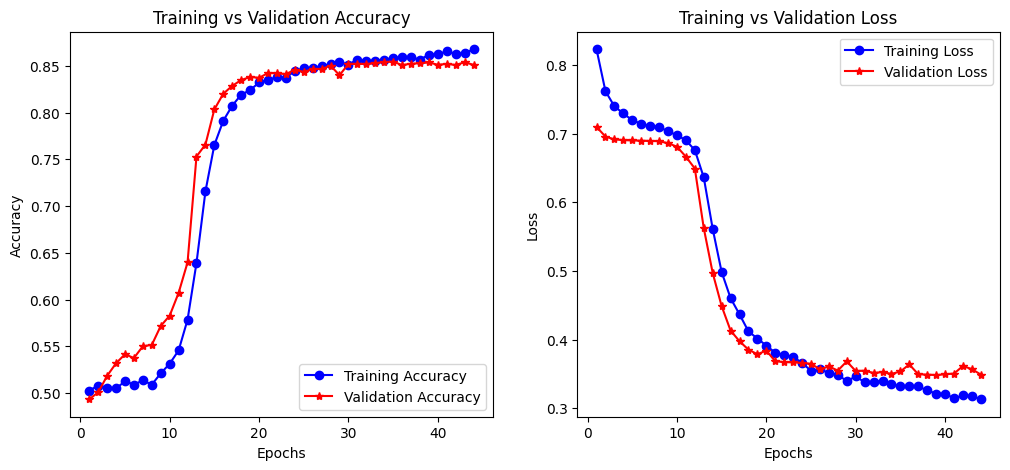

In [18]:
# Extract values from history
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [19]:
# Evaluate with a confusion matrix and classification report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
Confusion Matrix:
[[4149  726]
 [ 738 4387]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4875
           1       0.86      0.86      0.86      5125

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



# Train LSTM

In [20]:
# Define improved model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, input_length=max_sequence_length),  # Increased embedding size
    Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2)),  # Added recurrent dropout
    LayerNormalization(),  # Added normalization for stability
    Dropout(0.3),
    Bidirectional(LSTM(128, recurrent_dropout=0.2)),  
    LayerNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),  # Extra dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with lower learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.5218 - loss: 0.7495 - val_accuracy: 0.6384 - val_loss: 0.6600
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.5786 - loss: 0.6760 - val_accuracy: 0.7049 - val_loss: 0.5969
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.6716 - loss: 0.6014 - val_accuracy: 0.7541 - val_loss: 0.4983
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.7487 - loss: 0.5083 - val_accuracy: 0.7881 - val_loss: 0.4465
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.7907 - loss: 0.4543 - val_accuracy: 0.8109 - val_loss: 0.4159
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.8149 - loss: 0.4209 - val_accuracy: 0.8237 - val_loss: 0.3948
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.8272 - loss: 0.3926 - val_accuracy: 0.8243 - val_loss: 0.3891
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.8281 - loss: 0.3869 - val_accuracy: 0.8382 - val_loss: 0.

# Model Evaluation

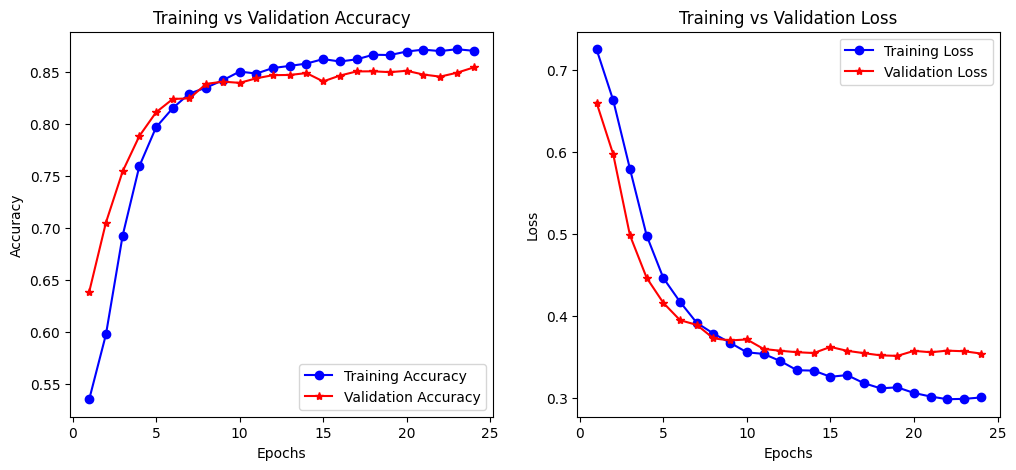

In [21]:
import matplotlib.pyplot as plt

# Extract values from history
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

# Train GRU 

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.5056 - loss: 1.0906 - val_accuracy: 0.5021 - val_loss: 0.9348
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.5069 - loss: 0.9249 - val_accuracy: 0.5035 - val_loss: 0.8881
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.5093 - loss: 0.8561 - val_accuracy: 0.5014 - val_loss: 0.8661
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.4921 - loss: 0.8372 - val_accuracy: 0.5018 - val_loss: 0.8506
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.5070 - loss: 0.8128 - val_accuracy: 0.5006 - val_loss: 0.8437
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5029 - loss: 0.7994 - val_accuracy: 0.4980 - val_loss: 0.8307
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.4996 - loss: 0.7954 - val_accuracy: 0.5006 - val_loss: 0.8228
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.5078 - loss: 0.7861 - val_accuracy: 0.5018 - val_loss:

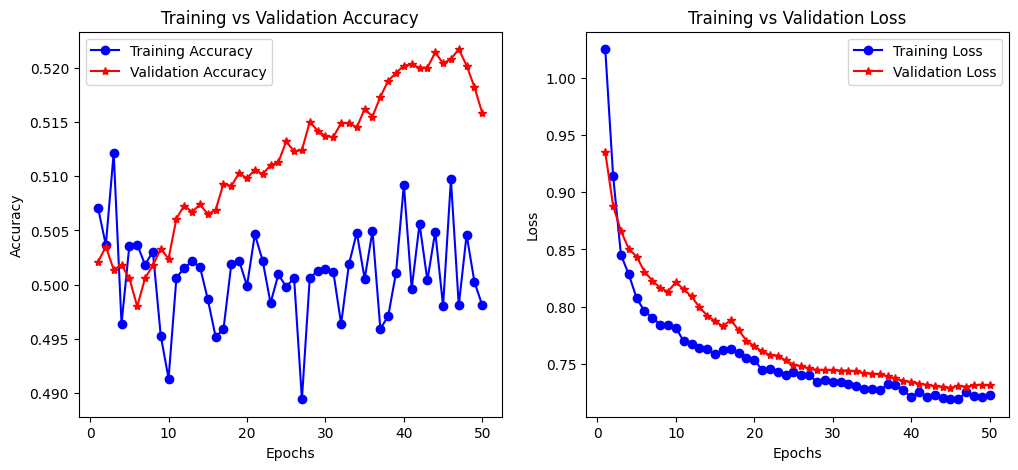

313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step
Confusion Matrix:
[[1899 2976]
 [1820 3305]]
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.39      0.44      4875
           1       0.53      0.64      0.58      5125

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.51     10000
weighted avg       0.52      0.52      0.51     10000



In [22]:
# Define improved GRU model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, input_length=max_sequence_length),  # Increased embedding size
    GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),  # GRU layer with dropout
    LayerNormalization(),  # Added normalization for stability
    GRU(128, dropout=0.3, recurrent_dropout=0.2),  # Second GRU layer
    LayerNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),  # Extra dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with lower learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Extract values from history
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()



# Evaluate with a confusion matrix and classification report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Detection System

In [23]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_sentiment(text, model, tokenizer, max_sequence_length=100):
    # clean text
    text = clean_text(text)
    # Convert text to sequence
    sequence = tokenizer.texts_to_sequences([text])
    
    # Pad sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    
    # Predict sentiment
    prediction = model.predict(padded_sequence)[0][0]  # Extract scalar value
    
    # Determine sentiments
    sentiment = "Positive 😊" if prediction > 0.5 else "Negative 😡"
    
    return sentiment, float(prediction)

# Example usage:
test_sentences = [
    "I love this product! It's amazing.",
    "This is the worst service I have ever experienced.",
    "The movie was okay, not great but not terrible either."
]

for sentence in test_sentences:
    sentiment, confidence = predict_sentiment(sentence, model, tokenizer)
    print(f"Text: {sentence}\nPredicted Sentiment: {sentiment} (Confidence: {confidence:.4f})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Text: I love this product! It's amazing.
Predicted Sentiment: Negative 😡 (Confidence: 0.3235)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Text: This is the worst service I have ever experienced.
Predicted Sentiment: Negative 😡 (Confidence: 0.3062)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Text: The movie was okay, not great but not terrible either.
Predicted Sentiment: Positive 😊 (Confidence: 0.5247)



In [26]:
model.save("lstm_model.h5")  # Saves architecture, weights & optimizer


import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [25]:
import tensorflow as tf
print(tf.__version__)

2.18.0
